
# BPM Analysis Simulations

In [3]:

import json
import xtrack as xt
import xpart as xp
import xobjects as xo
import PyNAFF
from matplotlib import pyplot as plt
import numpy as np

context = xo.ContextCpu()

#with open('../data/collider_thin.json') as f:
#    dct = json.load(f)

#line = xt.Line.from_dict(dct['lines']['lhcb1'])

#line_edited =line.copy()

collider = xt.Multiline.from_json('../data/collider_thin.json')

line = collider['lhcb1']
for ii in line.elements:
   # if ii is a type 'multipole' 
    if type(ii) == xt.beam_elements.elements.Multipole:
        if len(ii.knl)>2:
            #print(ii)
            ii.knl[2] = 0

line.vars['i_oct_b1'] = 0
#line.vars['i_sext_b1'] = 0

line_edited = line.copy()
plt.close('all')

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           


## One particle initialization and inserstion of the BPM monitors


In [4]:
#Only one particle
my_particle = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)
line.particle_ref = my_particle
num_turns = 1000
sampling_frequency = 11245.5

num_particles = 3
monitor_ip3 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,
                                    num_particles=num_particles)
monitor_ip5 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,
                                    num_particles=num_particles)
monitor_ip8 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,
                                    num_particles=num_particles)
line.insert_element(index='ip3', element=monitor_ip3, name='mymon3')
line.insert_element(index='ip5', element=monitor_ip5, name='mymon5')
line.insert_element(index='ip8', element=monitor_ip8, name='mymon8')




line.build_tracker()


monitor = xt.ParticlesMonitor(_context=context,
                              start_at_turn=0, stop_at_turn=num_turns,
                              num_particles=num_particles)
line.track(my_particle, num_turns=num_turns, freeze_longitudinal=True)

aux = line.twiss()

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_longitudinal`.


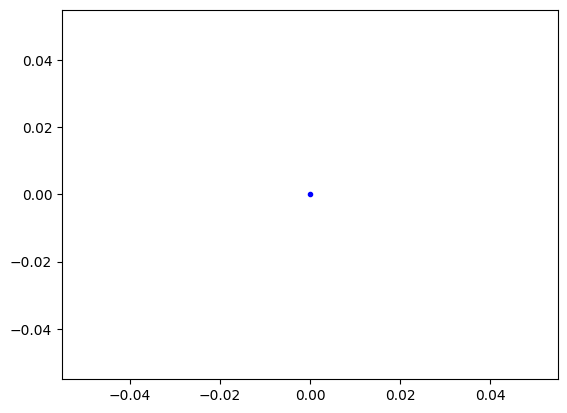

In [5]:
plt.plot(my_particle.x, my_particle.px, '.b') 

In [6]:
monitors = {}  # Create an empty dictionary to store the monitors
#num_particles = 2
#num_turns = 50
line_edited.discard_tracker()
for jj, ii in enumerate((['ip3']+list(aux[:, 'bpm.*']['name']))):
    #print(ii)
    monitor_name = f"mymon_{ii.replace('.', '_')}"
    #print(monitor_name=='bpm.8r6.b1')
    monitors[monitor_name] = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns, num_particles=num_particles)
    line_edited.insert_element(index=ii,
                                element=monitors[monitor_name], 
                                name=monitor_name)
                            



## Exciter with sine modulation at 10 Hz

In [7]:
# Exciter is working


f = 10
phi = 0
A = 1
sampling_frequency = 11245.5
total_time = num_turns / sampling_frequency
time = np.arange(0, total_time, 1/sampling_frequency)
samples = A * np.sin(2*np.pi*f*time + phi)


exciter = xt.Exciter(_context = context,
    samples = samples,
    sampling_frequency = sampling_frequency,
    #duration = 0.05,  # defaults to waveform duration   in sec, checked with the number of turns 0.05*11245.5=562.275
    duration= num_turns/sampling_frequency,
    frev = sampling_frequency,
    #start_turn = num_turns/10,  # default, seconds
    start_turn = 500*1/sampling_frequency ,  
    #knl = [0.00000001],  # default, no kick
    knl = [0.001]
     # default, no kick
    #knl = [1],
    #ksl = []
)
print(dir(line_edited.insert_element))

# Add it to the line for tracking as usual
'''
for i in range(0, num_turns):
    while i < num_turns:
        line.insert_element(
            element = exciter,
            name = 'RF_KO_EXCITER',
            index = 42,
        )
        i += 1    
'''


line_edited.insert_element(
    element = exciter,
    name = 'RF_KO_EXCITER',
    index = 42,
)

#insertion of the element in the beamline, the phase should be broken due to the kick



['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


In [8]:

line_edited.particle_ref = my_particle
line_edited.discard_tracker()
line_edited.build_tracker()
#print(line_edited.twiss()[:,'mymon_.*'])
#len(line_edited.twiss()[:,'mymon_.*']['mux'])


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [9]:
# generates a matched gaussian bunch and tracks it through the line
# the line is then edited to include BPMs and the bunch is tracked again
# the BPMs are then used to calculate the emittance of the bunch
# 
particles = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)#, x=[0.003, 0.002, 0.001])

particle_0 = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)#, x=[0.003, 0.002, 0.001])
#particle_0 = xp.Particles(
                 #   mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9, x=0.003)

#particles = xp.generate_matched_gaussian_bunch(line=line,
                                           #    num_particles=num_particles,
                                           #    nemitt_x=2.5e-6,
                                           #    nemitt_y=2.5e-6,
                                           #    sigma_z=9e-2, particle_ref=particles)
line_edited.track(particles, num_turns=num_turns, freeze_longitudinal=True)


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [10]:
line_edited.get_s_position(at_elements='mymon_bpmw_4l3_b1')

26636.4387

Text(0, 0.5, 'px [rad]')

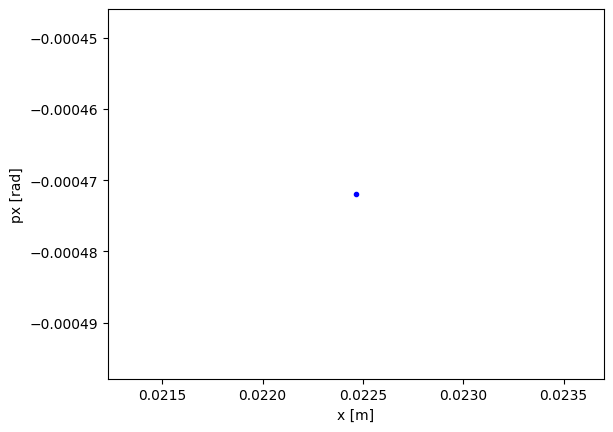

In [11]:
plt.plot(particles.x, particles.px, '.b')
plt.xlabel('x [m]')
plt.ylabel('px [rad]')

15000


1000


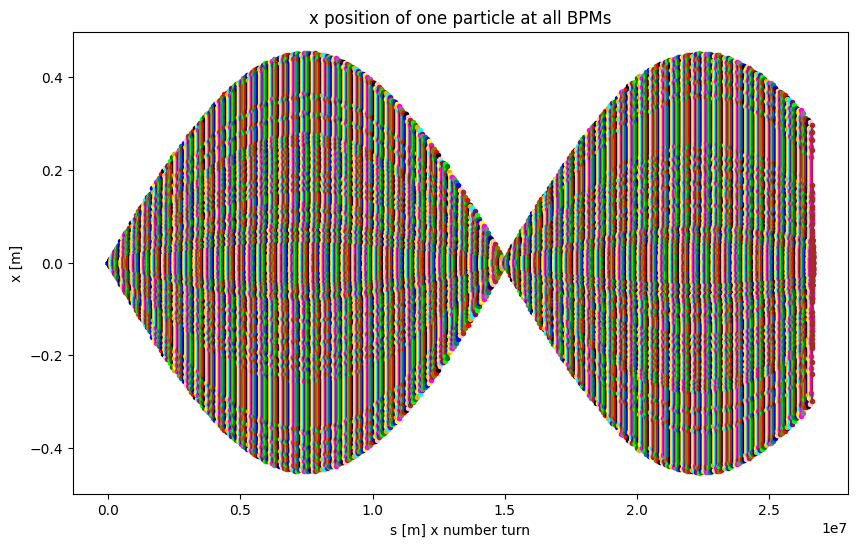

In [12]:

plt.figure(figsize=(10, 6))
#s_list = [monitors[ii].s[0,0] for ii in monitors]
#print(s_list[0])
#for jj in range(len(monitors)
n = np.arange(0, num_turns)
twiss = line_edited.twiss()
mux = twiss[:,'mymon.*'].mux
betx = twiss[:,'mymon.*'].betx
#print(betx)
#print(len(twiss['mux']))
#mux = twiss.mux
#print(len(mux))
#print(n)
x_list_all = []
x_list0 = []  
s_list0 = []
x_list_norm = []
c = 1000*['red', 'green', 'blue', 'black', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'brown', 'purple', 'gray', 'olive', 'lime', 'teal']
print(len(c))
for jj in n:
    #print(jj)
    x_list = [monitors[ii].x[0,jj] for ii in monitors]   #monitors[ii].x[i,j], i is the particle number, j is the turn number

    #x_list0 = [monitors[ii].x[0,0] for ii in monitors]
    s_list = [monitors[ii].s[0,jj] for ii in monitors]
    x_list_all.extend(x_list)
    x_list_norm.extend(x_list/np.sqrt(betx))


    #print(len(x_list_all))
    mon = monitors['mymon_ip3'].x[0,jj]  #just the first particle, one monitor for all turns
    mon_position = monitors['mymon_ip3'].s[0,jj]    
    #mux = twiss[:,'mymon_ip3'].mux
    #print(mux)
    x_list0.append(mon)  
    s_list0.append(mon_position) #

    #print(s_list)
    #plt.plot(s_list+(jj)*s_list[-1], x_list, '.-r')
    plt.plot((s_list + jj*s_list[-1]), x_list, '.-', color=c[jj])
    
    
    #plt.plot(mux, x_list/np.sqrt(betx), '.-r')
    #plt.xlim(0,4)

    
#plt.plot(s_list, x_list0, 1'.-b')
#print(s_list0)
x = np.fft.fft(x_list_all)

plt.xlabel('s [m] x number turn')
plt.ylabel('x [m]')
plt.title('x position of one particle at all BPMs')
print(len(x_list0))
plt.show()

#fft_try = abs(np.fft.fft(x_list0 - np.mean(x_list0)))
fft_try = np.fft.fft(x_list0) # fft of one monitor for all turns
fft_try = fft_try/len(fft_try)*2 #normalization
fft = fft_try.real + 1j*fft_try.imag 
# 
fft_used = abs(fft) - np.mean(abs(fft))
#freq_try = np.fft.fftfreq(len(fft_used), d = 1/len(fft_used))
#freq_try = np.fft.fftfreq(len(x_list0), d = 1/len(x_list0))

freq_try  =  np.linspace(0, sampling_frequency, len(fft_used))

plt.show()




(0.0, 20.0)

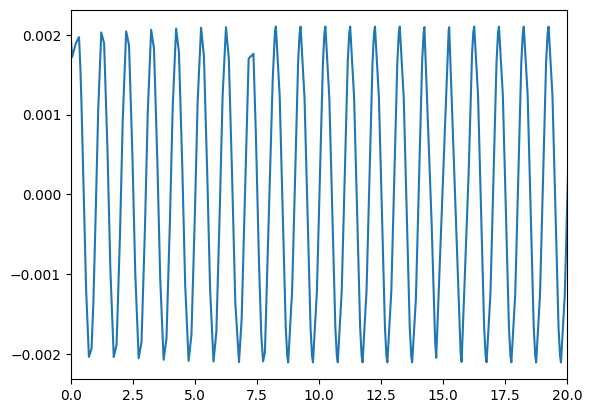

In [13]:
len(x_list/np.sqrt(betx))
plt.plot(mux, x_list/np.sqrt(betx))
plt.xlim(0,20)

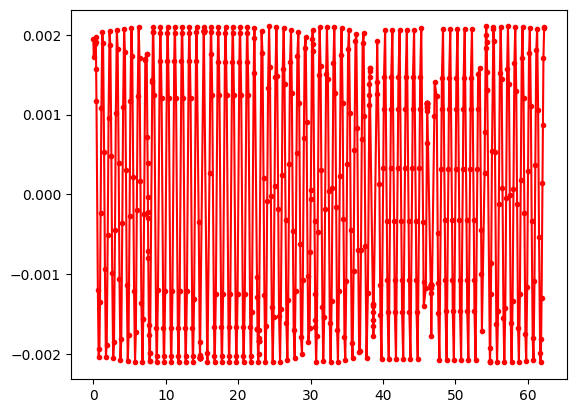

In [14]:
plt.plot(mux, x_list/np.sqrt(betx), '.-r')

Text(0, 0.5, 'x [m]')

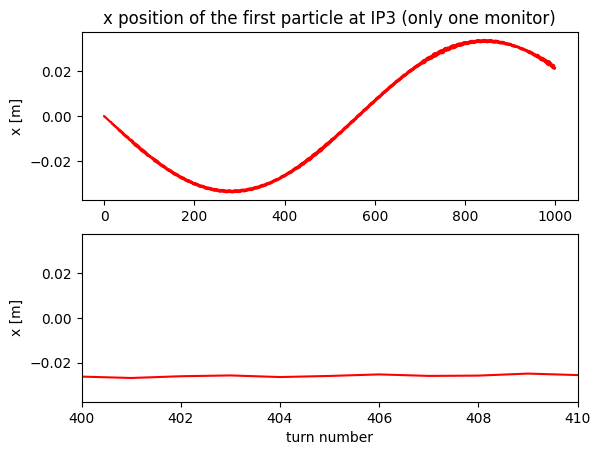

In [15]:
plt.subplot(2,1,1)
plt.title('x position of the first particle at IP3 (only one monitor)')
plt.plot(np.arange(num_turns), x_list0, '-r') 
plt.ylabel('x [m]')
plt.subplot(2,1,2)
plt.plot(np.arange(num_turns), x_list0, '-r')
plt.xlim(400, 410)
plt.xlabel('turn number')
plt.ylabel('x [m]')


amplitude_fit 0.0010578723437929768
frequency_fit 0.9998959096867641


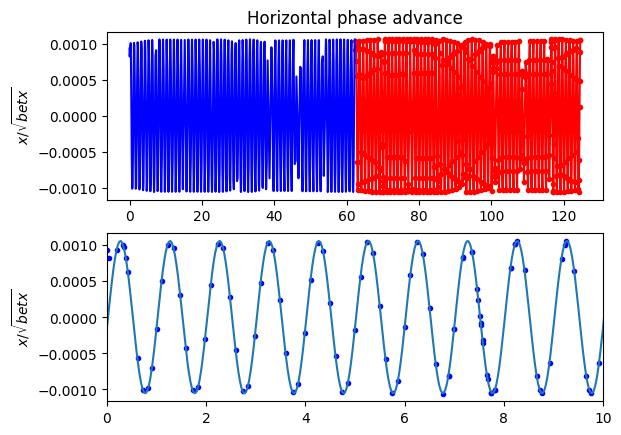

In [16]:
# Data for only the first turn, all BPMs
#print('betx', betx)
#y_data = x_list_all[len(mux)+1:len(mux)*2+1]/np.sqrt(betx)
#y_data_1 = x_list_all[0:len(mux)]/np.sqrt(betx)
mux = twiss[:,'mymon.*'].mux
n= -100

#y_data_1 = x_list_all[len(mux)*int(num_turns/2+2):len(mux)*int(num_turns/2+3)]/np.sqrt(betx)
#y_data = x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx)
#y_data_0 = x_list_all[len(mux)*int(num_turns/2+0):len(mux)*int(num_turns/2+1)]/np.sqrt(betx)
y_data_0 = x_list_all[len(mux)*int(721+n):len(mux)*int(722+n)]/np.sqrt(betx)
y_data = x_list_all[len(mux)*int(722+n):len(mux)*int(723+n)]/np.sqrt(betx)
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
def sine_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + offset

# Fit the sine function to the data
initial_guess = [1, 1, 0, 1]  # Initial guess for the parameters
fit_params, _ = curve_fit(sine_function, mux, y_data_0, p0=initial_guess)
fit_params1, _1 = curve_fit(sine_function, mux, y_data, p0=initial_guess)
# Extract the fitted parameters
amplitude_fit, frequency_fit, phase_fit, offset_fit = fit_params
amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1 = fit_params1

x_fine = np.linspace(min(mux), 2 * max(mux), 4000)
# Generate the fitted curve using the fitted parameters
y_fit = sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit)
y_fit1 = sine_function(x_fine, amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1)

fitted_sine_interpolated = interp1d(x_fine, sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit))
fitted_sine_interpolated1 = interp1d(x_fine, sine_function(x_fine, amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1))
y_fine = fitted_sine_interpolated(x_fine)
y_fine_1 = fitted_sine_interpolated1(x_fine)

y_fit = sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit)
plt.subplot(2,1,1)

#plt.plot(mux, x_list_all[0:len(mux)]/np.sqrt(betx), '.-r')
plt.plot(mux+mux[-1], y_data, '.-r')
plt.plot(mux, y_data_0, '-b')
#plt.plot(mux+2*mux[-1], y_data_1, '.-g')
#plt.plot(x_fine, y_fine)
#plt.xlim(0,10)
#plt.plot(mux, x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx), '.-r')
#plt.plot(x_fine,y_fine, '-b')
plt.title('Horizontal phase advance')
plt.ylabel('$x/\sqrt{betx}$')
plt.subplot(2,1,2)
#plt.plot(mux, x_list_all[0:len(mux)]/np.sqrt(betx), '.-r')
#plt.plot(mux, y_data, '.-r')#
plt.plot(mux + mux[-1], y_data, '.r')
plt.plot(mux, y_data_0, '.b')
plt.plot(x_fine, y_fine)
plt.plot(x_fine+x_fine[-1]/2, y_fine_1)
#plt.plot(mux+2*mux[-1], y_data_1, '.-g')
#plt.plot(mux, x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx), '.-r')
#plt.plot(x_fine,y_fine, '-b')
#plt.xlim(mux[-1]*2-mux[10], mux[-1]*2+ mux[10])
#plt.xlim(61.7, 64)
plt.xlim(0,10)
#print('mux', twiss[:,'mymon.*'].mux)
#print('len mux', len(twiss[:,'mymon.*'].mux)))
plt.ylabel('$x/\sqrt{betx}$')
print('amplitude_fit', amplitude_fit)
print('frequency_fit', frequency_fit)



# Localization of the broken phase
 - One can find a period where the phase is not broken and fit the function, then one extends the fit for all the data and looks where the error grows.
 - Due to the small number of data points (BPMs) a more fine grid is implemented and the closest phase value localized.
 - This value is then compared to the horizontal displacement and the fit horizontal displacement without a broken phase
 - Clearly the breaking in the phase can be seen exactly as expected

y_diff [-2.60684273e-05 -7.51705711e-05  7.28388512e-04  1.52988950e-03
  1.49412556e-03  1.61682003e-03  1.51286768e-03  1.36558756e-04
 -9.93942312e-04 -1.50516081e-03 -1.60165238e-03 -1.11976896e-03
 -2.02509574e-04  9.74380198e-04  1.63511279e-03  1.27974243e-03
  2.79860841e-04 -9.73191601e-04 -1.62744609e-03 -1.27292638e-03]
y_diff0 [ 1.07020238e-03  5.49045252e-04  1.67310060e-05 -2.25437977e-05
  1.87091924e-05 -3.13278679e-05  8.11975094e-05  6.07709823e-05
 -2.06935773e-05 -3.20708514e-05  4.99262153e-06  4.09392465e-06
 -1.13702729e-04  1.47168457e-05  3.55095979e-06 -6.67340746e-05
 -6.38024777e-07  2.57161647e-05 -4.50624737e-07 -1.16400403e-04]
1136
1136


Text(0, 0.5, '$x/\\sqrt{betx}$ - $x_{fit}$')

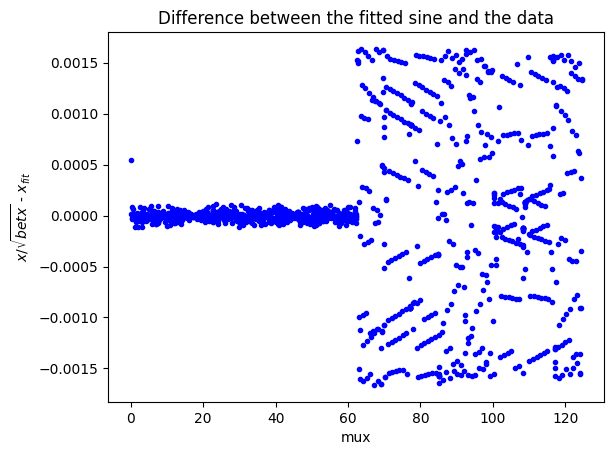

In [17]:
#% find the closest x_fine value to mux



closest_ind_all = []
x_close_all = []
y_close_all = []
y_diff = []
y_diff0 = []
mux = twiss[:,'mymon.*'].mux
mux = np.append(mux, mux + mux[-1])
for i in range(len(mux)):
    y_close = []
    closest_ind = []
    x_close = []
    closest_ind = np.argmin(np.abs(x_fine - (mux[i])))
    closest_ind_all.append(closest_ind)
    x_close = x_fine[closest_ind]
    x_close_all.append(x_close)
    y_close = y_fine[closest_ind]
    y_close_all.append(y_close)
    
y_diff_all = []
y_diff = y_data - y_close_all[len(y_data):]
y_diff0 = y_data_0 - y_close_all[:len(y_data)]
y_diff_all = np.append(y_diff0, y_diff)
    
#print('closest_ind_all', closest_ind_all)
#print('y_close', y_close_all)
#print(len(y_close_all))



print('y_diff', y_diff[:20])
print('y_diff0', y_diff0[:20])
print(len(closest_ind_all))
print(len(mux))
for i in range(len(y_diff_all)):
    if i > 1e-10:
        plt.plot(mux[i], y_diff_all[i], '.b')
plt.title('Difference between the fitted sine and the data')
plt.xlabel('mux')
plt.ylabel('$x/\sqrt{betx}$ - $x_{fit}$')



# Phase advance between the signals

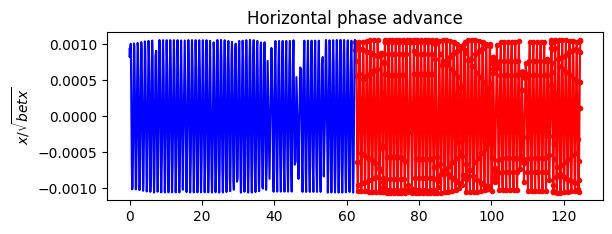

amplitude_fit 0.0010578723437929768
frequency_fit 0.9998959096867641
-0.1347823657989455


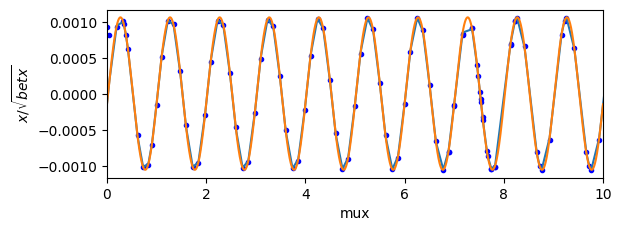

In [18]:
# Data for only the first turn, all BPMs
#print('betx', betx)
#y_data = x_list_all[len(mux)+1:len(mux)*2+1]/np.sqrt(betx)
#y_data_1 = x_list_all[0:len(mux)]/np.sqrt(betx)
mux = twiss[:,'mymon.*'].mux
n= -100

#y_data_1 = x_list_all[len(mux)*int(num_turns/2+2):len(mux)*int(num_turns/2+3)]/np.sqrt(betx)
#y_data = x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx)
#y_data_0 = x_list_all[len(mux)*int(num_turns/2+0):len(mux)*int(num_turns/2+1)]/np.sqrt(betx)
y_data_0 = x_list_all[len(mux)*int(721+n):len(mux)*int(722+n)]/np.sqrt(betx)
y_data = x_list_all[len(mux)*int(722+n):len(mux)*int(723+n)]/np.sqrt(betx)
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
def sine_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + offset

# Fit the sine function to the data
initial_guess = [1, 1, 0, 1]  # Initial guess for the parameters

fit_params, _ = curve_fit(sine_function, mux, y_data_0, p0=initial_guess)
fit_params1, _1 = curve_fit(sine_function, mux, y_data, p0=initial_guess)
# Extract the fitted parameters
amplitude_fit, frequency_fit, phase_fit, offset_fit = fit_params
amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1 = fit_params1

x_fine = np.linspace(min(mux),  max(mux), 100000)
# Generate the fitted curve using the fitted parameters

y_fit_data = sine_function(mux, amplitude_fit, frequency_fit, phase_fit, offset_fit)
y_fit = sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit)
y_fit1 = sine_function(x_fine, amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1)

#fitted_sine_interpolated_data = interp1d(mux, sine_function(mux, amplitude_fit, frequency_fit, phase_fit, offset_fit))
fitted_sine_interpolated = interp1d(x_fine, sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit))
fitted_sine_interpolated1 = interp1d(x_fine, sine_function(x_fine, amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1))

#y_notfine = fitted_sine_interpolated_data(mux)
y_fine = fitted_sine_interpolated(x_fine)
y_fine_1 = fitted_sine_interpolated1(x_fine)


plt.subplot(2,1,1)

#plt.plot(mux, x_list_all[0:len(mux)]/np.sqrt(betx), '.-r')
plt.plot(mux+mux[-1], y_data, '.-r')
plt.plot(mux, y_data_0, '-b')
#plt.plot(mux+2*mux[-1], y_data_1, '.-g')
#plt.plot(x_fine, y_fine)
#plt.xlim(0,10)
#plt.plot(mux, x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx), '.-r')
#plt.plot(x_fine,y_fine, '-b')
plt.title('Horizontal phase advance')
plt.ylabel('$x/\sqrt{betx}$')
plt.show()
plt.subplot(2,1,2)
#plt.plot(mux, x_list_all[0:len(mux)]/np.sqrt(betx), '.-r')
#plt.plot(mux, y_data, '.-r')#
plt.plot(mux + mux[-1], y_data, '.r')
plt.plot(mux, y_data_0, '.b')
plt.plot(mux, y_fit_data)
plt.plot(x_fine, y_fine)
plt.plot(x_fine+x_fine[-1], y_fine_1)
#plt.plot(mux+2*mux[-1], y_data_1, '.-g')
#plt.plot(mux, x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx), '.-r')
#plt.plot(x_fine,y_fine, '-b')
#plt.xlim(mux[-1]*2-mux[10], mux[-1]*2+ mux[10])
#plt.xlim(61.7, 64)
plt.xlim(0,10)
#print('mux', twiss[:,'mymon.*'].mux)
#print('len mux', len(twiss[:,'mymon.*'].mux))
#print('twiss.mux', len(twiss.mux))

plt.xlabel('mux')
plt.ylabel('$x/\sqrt{betx}$')
print('amplitude_fit', amplitude_fit)
print('frequency_fit', frequency_fit)
print(phase_fit)





(40.0, 50.0)

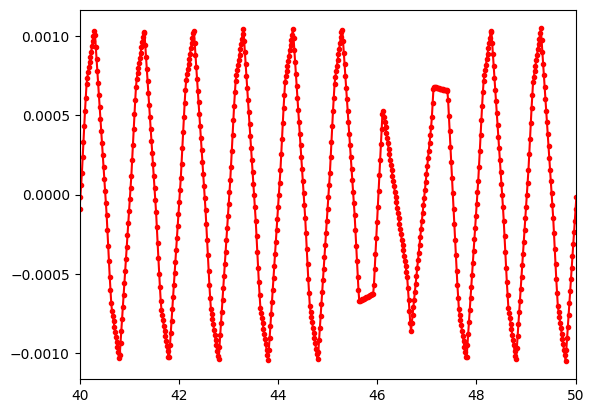

In [19]:
y  = interp1d(mux, y_data_0)
plt.plot(np.linspace(min(mux), max(mux), 4000), y(np.linspace(min(mux), max(mux), 4000)), '.-r')
plt.xlim(40,50)

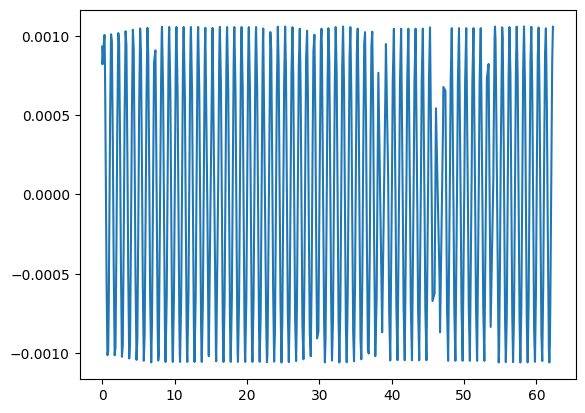

In [20]:
turn_0 = y_data_0
turn_1 = y_data

mux = twiss[:,'mymon.*'].mux 
plt.plot(mux, turn_0)
#plt.plot(mux, turn_1)

#plt.plot(turn_1)
#plt.xlim([100,150])

[-0.         -0.01705451 -0.03409906 ...  0.05112369  0.03409906
  0.01705451] [-0.         -0.01449003 -0.02897394 ...  0.04344563  0.02897394
  0.01449003]
angle_before 389.29556430567544


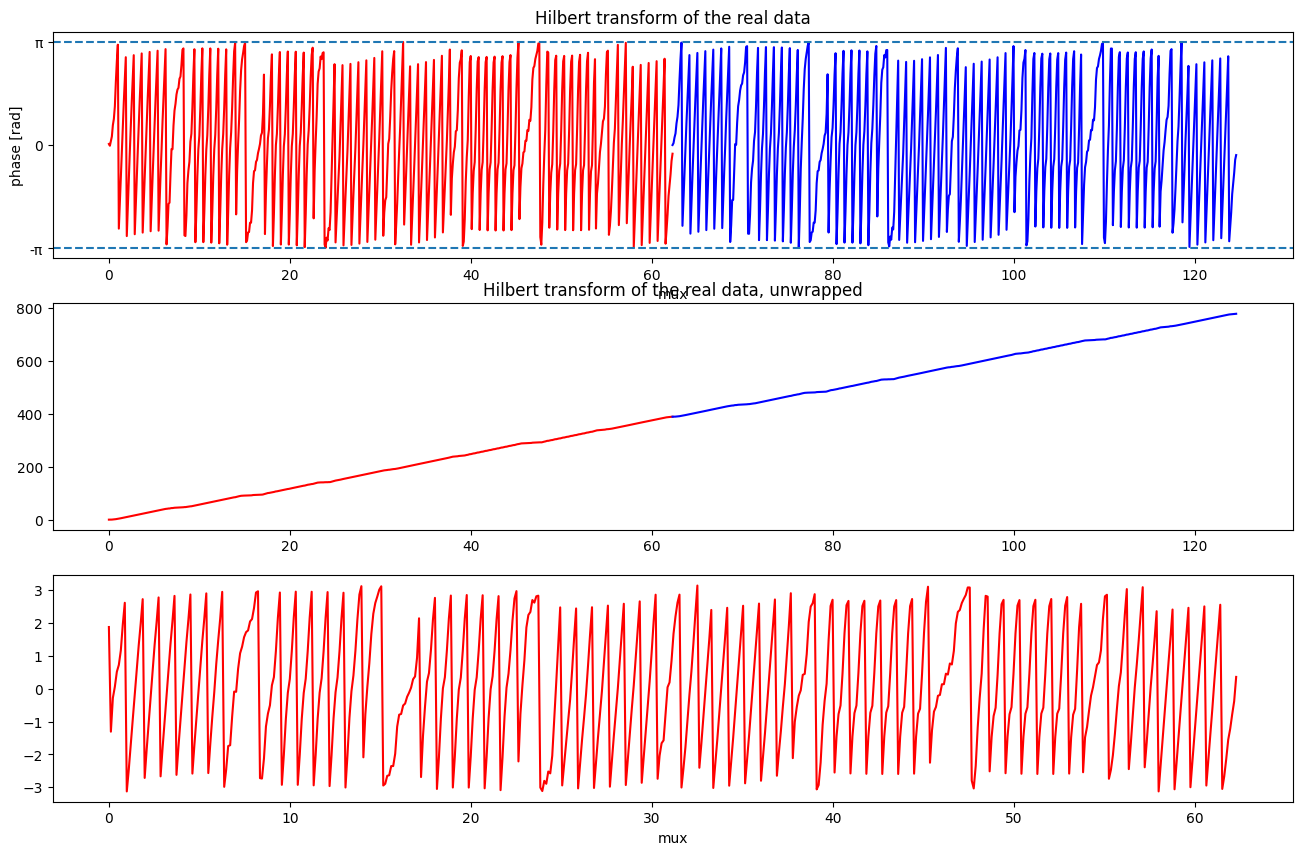

In [21]:
# Phase advance
#cross_corr = np.correlate(signal1, signal2, mode='full')

from scipy.fft import fft
from scipy.signal import hilbert


angle_before = np.angle(fft(y_fit))
angle_after = np.angle(fft(y_fine_1))
print(angle_before, angle_after)

hilbert_before_datafit = np.angle(hilbert(y_fit_data))
hilbert_before_fit = np.angle(hilbert(y_fit))
hilbert_before = np.angle(hilbert(y_data_0))
hilbert_after_fit = np.angle(hilbert(y_fit1))
hilbert_after = np.angle(hilbert(y_data))

angle_hbefore_datafit = np.unwrap(hilbert_before_datafit)
angle_hbefore_fit = np.unwrap(hilbert_before_fit)
angle_hafter_fit = np.unwrap(hilbert_after_fit)

t_fit_datafit = np.linspace(0, mux[-1], len(angle_hbefore_datafit))
t_fit = np.linspace(0, mux[-1], len(angle_hbefore_fit))
t_fit_after = np.linspace(mux[-1], 2*mux[-1], len(angle_hafter_fit))


angle_hbefore = np.unwrap(hilbert_before)
angle_hafter = np.unwrap(hilbert_after)
t = np.linspace(0, mux[-1], len(angle_hbefore))
t_after = np.linspace(mux[-1], 2*mux[-1], len(angle_hafter))


plt.figure(figsize=(16,10))

plt.subplot(3,1,1)
plt.title('Hilbert transform of the real data')
plt.plot(t, hilbert_before, '-r')
plt.plot(t_after, hilbert_after, '-b' )
plt.axhline(y=np.pi, linestyle='dashed')
plt.axhline(y=-np.pi, linestyle='dashed')
plt.yticks([np.pi, 0, -np.pi], ['π', 0, '-π'])
plt.xlabel('mux')
plt.ylabel('phase [rad]')
plt.subplot(3,1,2)
plt.title('Hilbert transform of the real data, unwrapped')
plt.plot(t, angle_hbefore, '-r')
plt.plot(t_after, angle_hafter + angle_hbefore[-1], '-b')

plt.subplot(3,1,3)
plt.plot(t_fit_datafit, hilbert_before_datafit, '-r')

plt.xlabel('mux')
print('angle_before', angle_hbefore[-1])

#plt.xlim(0, 0.2)
#plt.xlim(0, 0.2)

# One can localize the positions of the BPMs on the LHC where the phase advance is broken 

(370.0, 400.0)

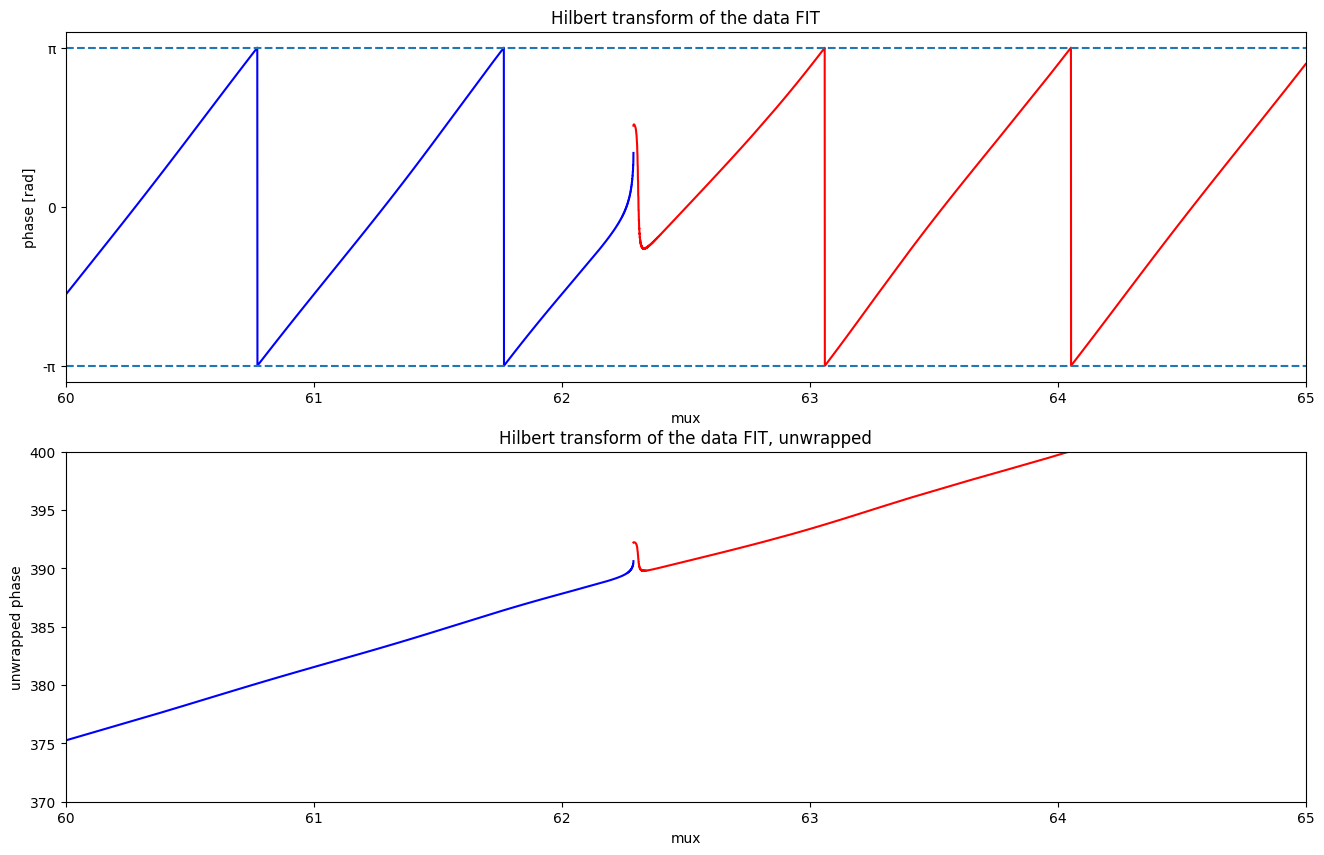

In [22]:
plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
plt.plot(t_fit, hilbert_before_fit, '-b')
plt.plot(t_fit_after, hilbert_after_fit, '-r')
plt.axhline(y=np.pi, linestyle='dashed')
plt.yticks([np.pi, 0, -np.pi], ['π', 0, '-π'])
plt.axhline(y=-np.pi, linestyle='dashed')
plt.xlim(60,65)

plt.title('Hilbert transform of the data FIT')

plt.xlabel('mux')
plt.ylabel('phase [rad]')
plt.subplot(2,1,2)
plt.title('Hilbert transform of the data FIT, unwrapped')

plt.xlabel('mux')
plt.ylabel('$x/\sqrt{betx}$')
t_fit = np.linspace(0, mux[-1], len(angle_hbefore_fit))
t_fit_after = np.linspace(mux[-1], 2*mux[-1], len(angle_hafter_fit))


plt.ylabel('unwrapped phase')
plt.plot(t_fit, angle_hbefore_fit, '-b')
plt.plot(t_fit_after, angle_hafter_fit+angle_hbefore_fit[-1], '-r')
plt.xlim(60,65)
plt.ylim(370, 400)


3.1324316144851583


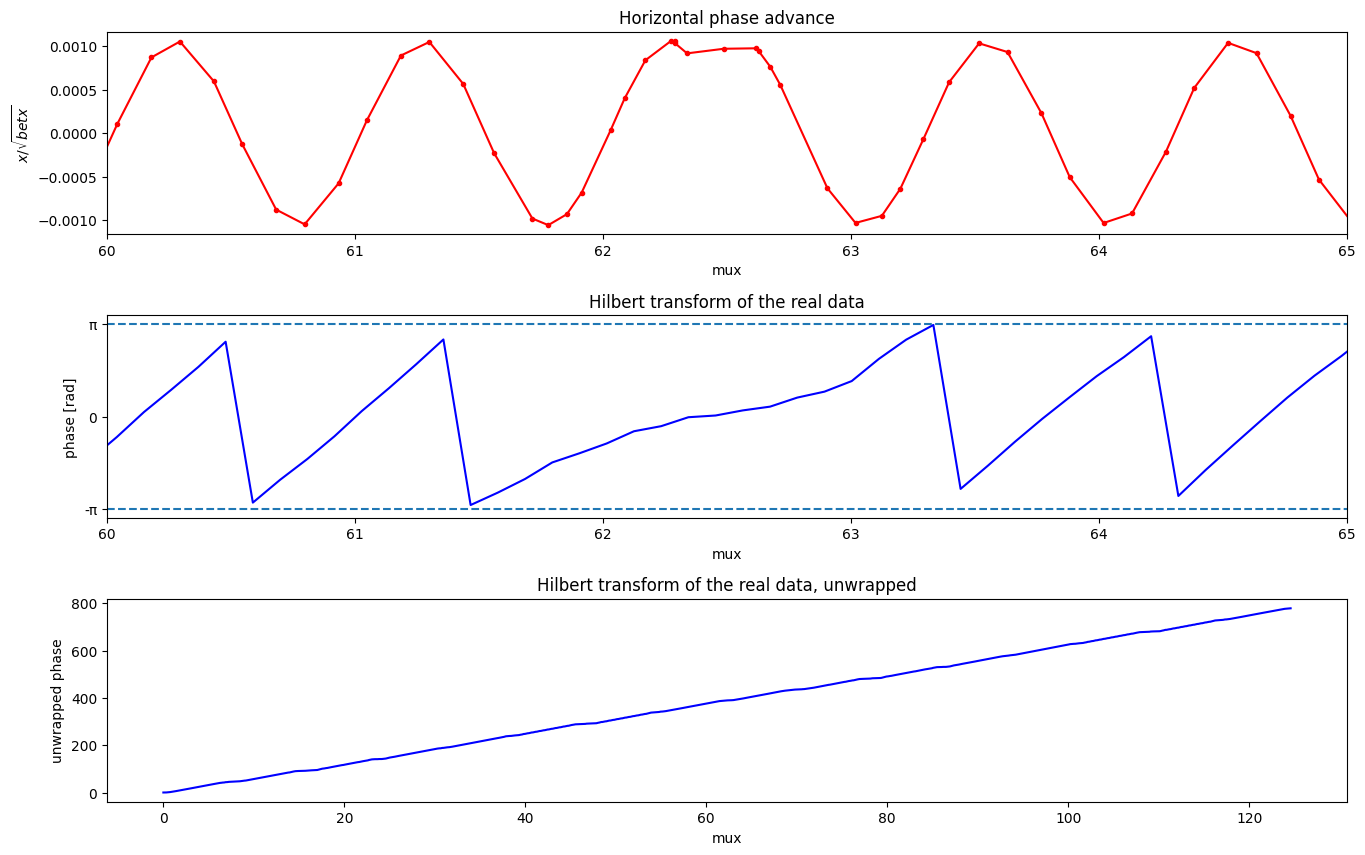

In [23]:
y_data_norm0 = x_list_norm[len(mux)*int(721+n):len(mux)*int(723+n)]
y_data_norm = x_list_norm[len(mux)*int(722+n):len(mux)*int(724+n)]

mux_ext = np.append(mux, mux + mux[-1])

plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(mux_ext, y_data_norm0, '.-r')
plt.xlim(60,65)
plt.xlabel('mux')
plt.ylabel('$x/\sqrt{betx}$')
plt.title('Horizontal phase advance')

t_norm = np.linspace(0, 2*mux[-1], len(mux_ext))
hilbert_before_norm = np.angle(hilbert(y_data_norm0))


angle_hbefore_norm = np.unwrap(hilbert_before_norm)

plt.subplot(3,1,2)
plt.plot(t_norm, hilbert_before_norm, '-b')
plt.axhline(y=np.pi, linestyle='dashed')
plt.axhline(y=-np.pi, linestyle='dashed')
plt.xlabel('mux')
plt.ylabel('phase [rad]')
plt.title('Hilbert transform of the real data')

plt.xlim(60,65)
plt.yticks([np.pi, 0, -np.pi], ['π', 0, '-π'])
plt.subplot(3,1,3)
plt.plot(t_norm, angle_hbefore_norm, '-b')
#plt.xlim(60,65)
#plt.ylim(370, 420)
plt.xlabel('mux')
plt.ylabel('unwrapped phase') 
plt.title('Hilbert transform of the real data, unwrapped')
plt.subplots_adjust(hspace=0.4)
print(max(hilbert_before_norm))

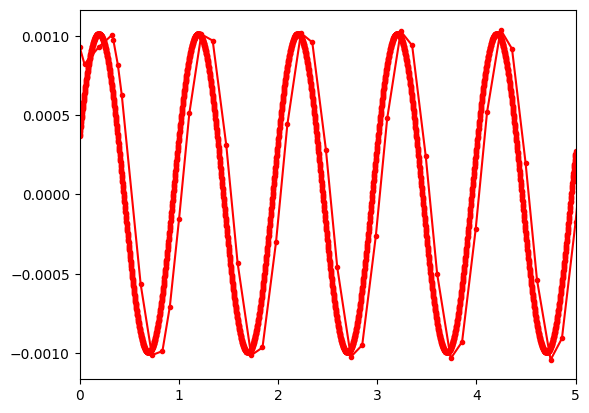

In [24]:
fit_params_norm, _norm = curve_fit(sine_function, mux_ext, y_data_norm0, p0=initial_guess)
fit_params1_norm, _norm1 = curve_fit(sine_function, mux_ext, y_data_norm, p0=initial_guess)
# Extract the fitted parameters
amplitude_fit_norm, frequency_fit_norm, phase_fit_norm, offset_fit_norm = fit_params_norm
amplitude_fit1_norm, frequency_fit1_norm, phase_fit1_norm, offset_fit1_norm = fit_params1_norm

x_fine_norm = np.linspace(min(mux),  2*max(mux), 100000)
# Generate the fitted curve using the fitted parameters
y_fit_norm = sine_function(x_fine_norm, amplitude_fit_norm, frequency_fit_norm, phase_fit_norm, offset_fit_norm)
y_fit1_norm = sine_function(x_fine_norm, amplitude_fit1_norm, frequency_fit1_norm, phase_fit1_norm, offset_fit1_norm)

fitted_sine_interpolated_norm = interp1d(x_fine_norm, sine_function(x_fine_norm, amplitude_fit_norm, frequency_fit_norm, phase_fit_norm, offset_fit_norm))
fitted_sine_interpolated1_norm = interp1d(x_fine_norm, sine_function(x_fine_norm, amplitude_fit1_norm, frequency_fit1_norm, phase_fit1_norm, offset_fit1_norm))
y_fine_norm = fitted_sine_interpolated_norm(x_fine_norm)
y_fine_1_norm = fitted_sine_interpolated1_norm(x_fine_norm)

plt.plot(x_fine_norm,y_fit_norm, '.-r')
plt.xlim(0,5)
plt.plot(mux_ext, y_data_norm0, '.-r')

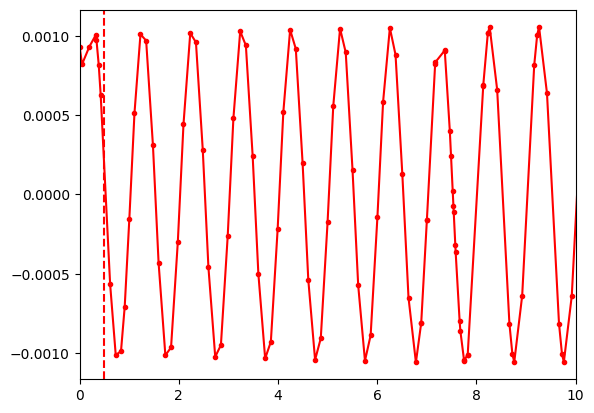

In [25]:
plt.plot(mux, y_data_0, '.-r')
plt.xlim(0,10)
plt.axvline(x=0.5, color='r', linestyle='--')

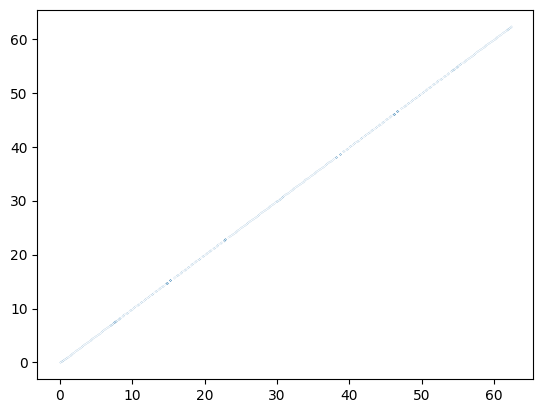

In [26]:
plt.plot(twiss[['mux'],'mymon_.*'],twiss[['mux'],'mymon_.*'],'.',ms=.1)

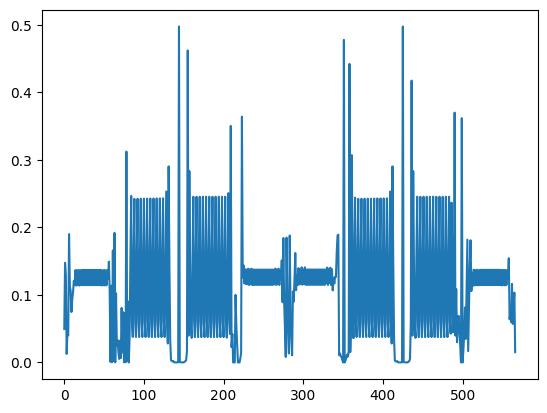

In [27]:
plt.plot(np.diff(twiss[['mux'],'mymon_.*']))

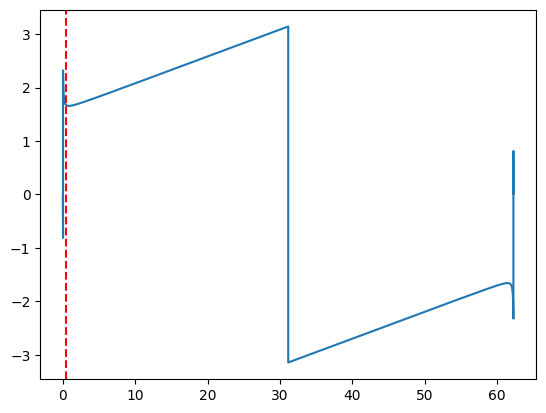

In [28]:
plt.plot(x_fine, angle_before)
#plt.xlim(0,1)
plt.axvline(x=0.5, color='r', linestyle='--')

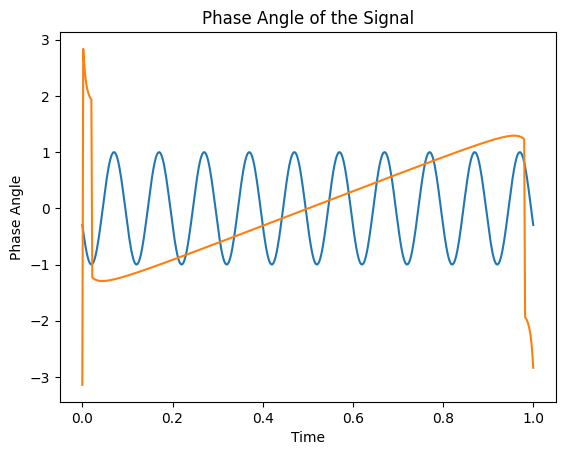

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

# Signal parameters
frequency = 10  # Frequency of the sine wave in Hz
phase =-np.pi +0.3# Phase angle in radians
#phase = 0
# Time values
t = np.linspace(0, 1, num=500)

# Generate the signal
signal = np.sin(2 * np.pi * frequency * t + phase)

spectrum = fft(signal)

# Extract phase angle
phase_angle = np.angle(spectrum)
plt.plot
plt.plot(t, signal)
# Plot the phase angle
plt.plot(t, phase_angle)
plt.xlabel('Time')
plt.ylabel('Phase Angle')
plt.title('Phase Angle of the Signal')
plt.show()

568000
[60.54535007 60.6822344  60.79695972 60.93410647 61.04824545 61.18514208
 61.29987138 61.43646687 61.56097568 61.71541276 61.77944838 61.85437561
 61.91403845 62.03045918 62.0875448  62.17090122 62.27427411 62.28947783
 62.28947783 62.33910607 62.48674349 62.61627608 62.62890387 62.67479872
 62.7149366  62.90517067 63.01821211 63.12437992 63.19914327 63.29191185
 63.39558227 63.51669168 63.63122057 63.76812928 63.8820816  64.01866763
 64.13320057 64.27010098 64.38404993 64.52064428 64.63518054 64.77231106
 64.88684734 65.02397786 65.13851413 65.27564466 65.39018093 65.52731146
 65.64184773 65.77897825]
[[ 6.03133377e+03  1.93043667e-04]
 [ 6.03139462e+03  7.59039606e-04]
 [ 6.03143222e+03  1.05869974e-03]
 ...
 [ 6.57905839e+03  1.35286051e-03]
 [ 6.57907421e+03  1.45045384e-03]
 [ 6.57951659e+03 -1.03367519e-03]]


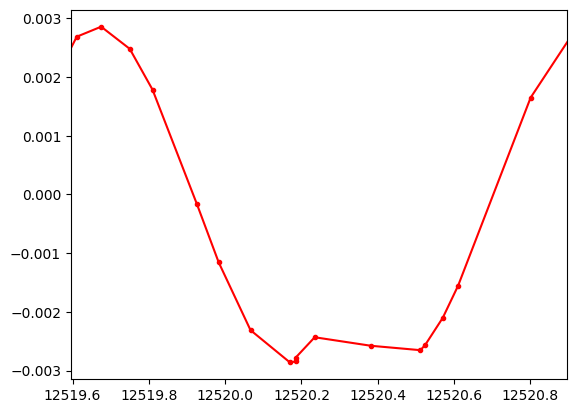

In [30]:
mux_all_list = []
for i in range(num_turns):
    mux_all = mux + i*mux[-1]
    mux_all_list = np.append(mux_all_list, mux_all)
number = 200
print(len(mux_all_list))
used_x = np.array(x_list_norm[len(mux)*number:len(mux)*(number+2)])/1
used_mux = np.array(mux_all_list[len(mux)*number:len(mux)*(number+2)])/1
print(mux_all_list[550:600])
data = np.stack((mux_all_list, x_list_norm))
print(data.T[55000:60000])
plt.plot(used_mux, used_x, '.-r')

plt.xlim(mux_all_list[len(mux)*number]+61.7, mux_all_list[len(mux)*(number)]+63)
#plt.xlim(40250.7, 40300)
#plt.ylim(-0.5e-8, 0.5e-8)
plt.show()

12457.895565781619


/tmp/ipykernel_3587375/3095921549.py:13: RuntimeWarning: invalid value encountered in sqrt
  return a * np.cos(np.sqrt(x**2-phi_si**2)-np.pi*0.31+c)
/home/aradosla/2023_07_13_test_with_Guido/miniforge/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


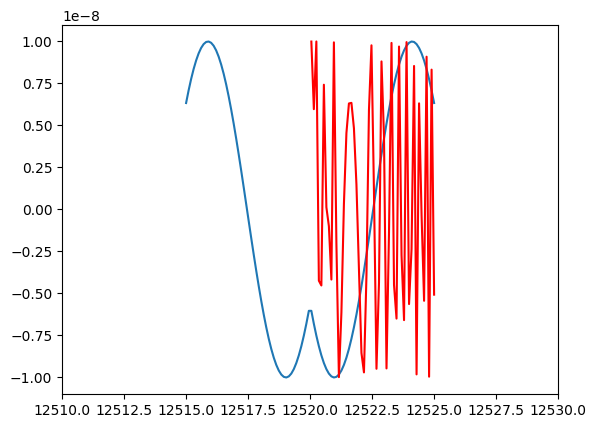

(12510.0, 12530.0)

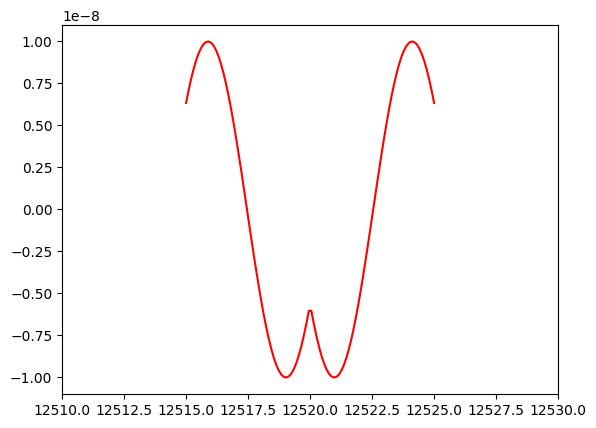

In [31]:
theta = np.linspace(-4,4, 1000)
theta1 = np.linspace(-4,4, 1000)
theta = np.linspace(min(mux_all_list[len(mux)*number:len(mux)*(number+2)]),max(mux_all_list[len(mux)*number:len(mux)*(number+2)]), 1000)
theta = np.linspace(12515, 12525, 100)
print(min(mux_all_list[len(mux)*number:len(mux)*(number+2)]))
c = np.pi
a = 1e-8
phi_si = 12520

f = a * np.cos(abs(theta-phi_si)-np.pi*0.31+c)
plt.plot(theta, f)
def fit_function(x, amp, phase, offset):
    return a * np.cos(np.sqrt(x**2-phi_si**2)-np.pi*0.31+c)
# Fit the sine function to the data
initial_guess = [1,phi_si, c]  # Initial guess for the parameters

#fit_params_cos, _cos = curve_fit(fit_function, mux_all_list[len(mux)*number:len(mux)*(number*2)], x_list_norm[len(mux)*number:len(mux)*(number+2)], p0=initial_guess)
fit_params_cos, _cos = curve_fit(fit_function, used_mux, used_x, p0=initial_guess)
amplitude_fit_cos, phase_fit_cos, offset_fit_cos = fit_params_cos
y_fit_cos = fit_function(theta, amplitude_fit_cos,phase_fit_cos, offset_fit_cos)


#fitted_sine_interpolated = interp1d(x_fine, sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit))
#fitted_sine_interpolated1 = interp1d(x_fine, sine_function(x_fine, amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1))
#y_fine = fitted_sine_interpolated(x_fine)
#y_fine_1 = fitted_sine_interpolated1(x_fine)
#plt.xlim(plt.xlim(mux_all_list[len(mux)*number]+61.7, mux_all_list[len(mux)*(number)]+63))
plt.plot(theta, y_fit_cos, '-r')
plt.plot()
plt.xlim(12510,12530)
plt.show()
plt.plot(theta, a * np.cos(abs(theta-phi_si)-np.pi*0.31+c), '-r')
plt.xlim(12510,12530)


The 10 Hz is now 11.2455


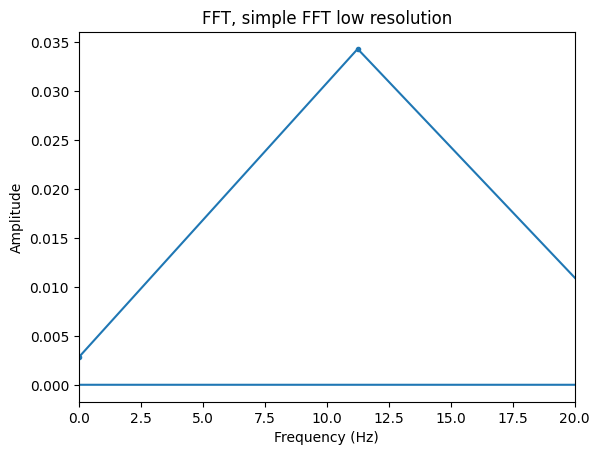

In [32]:
fft_try = np.fft.fft(x_list0)

# Normalize the FFT result
fft_normalized = fft_try / len(fft_try)*2

# Calculate the frequency axis
sampling_frequency = 11245.5 # Adjust this to match your actual sampling frequency
freq_try = np.fft.fftfreq(len(fft_normalized), d=1/sampling_frequency)


# Calculate the amplitude spectrum
fft_amplitude = np.abs(fft_normalized)


# Plot the frequency spectrum
plt.plot(freq_try, fft_amplitude, '.-')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT, simple FFT low resolution")
plt.xlim(0, sampling_frequency / 2)  # Nyquist frequency
plt.xlim(0,20)

#print('The tune is', freq_try[np.argmax(fft_amplitude)]/sampling_frequency)
print('The 10 Hz is now', freq_try[np.argmax(fft_amplitude)])
plt.show()

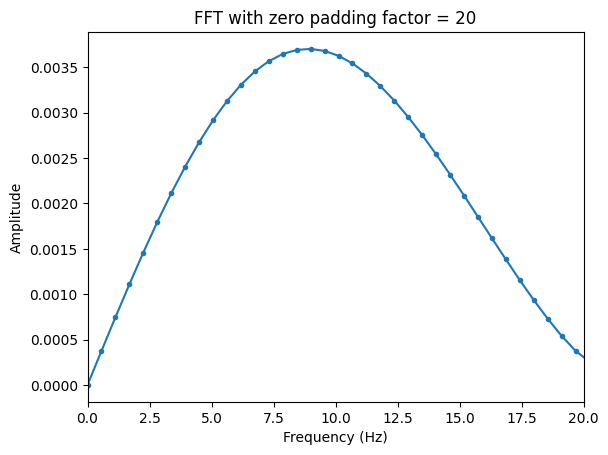

10 Hz 8.9964


In [33]:
# Zero padding
zero_padding_factor = 20
fft_try = np.fft.rfft(x_list0-np.mean(x_list0), n = len(x_list0) * zero_padding_factor)
#print(len(fft_try))
# Normalize the FFT result
fft_normalized = fft_try / len(fft_try)*2

# Calculate the frequency axis
sampling_frequency = 11245.5 # Adjust this to match your actual sampling frequency
freq_try = np.fft.rfftfreq(len(x_list0) *  zero_padding_factor, d=1/sampling_frequency)
#print(len(freq_try))


# Calculate the amplitude spectrum
fft_amplitude = np.abs(fft_normalized)
#print(fft_amplitude)


# Plot the frequency spectrum
plt.plot(freq_try, fft_amplitude, '.-')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT with zero padding factor = 20")
#plt.xlim(0.22, 0.4)  # Nyquist frequency
plt.xlim(0,20)  
plt.show()
#print('The tune is', freq_try[np.argmax(fft_amplitude)]/sampling_frequency)
print('10 Hz', freq_try[np.argmax(fft_amplitude[0:1000])])

In [34]:
twiss.dqx 

-352.71085168247396

[0.00000000e+00 8.89244587e-05 1.77848917e-04 ... 8.88977813e-01
 8.89066738e-01 8.89155662e-01]
-100


"\ntotal_time = n_turns / f_rev\ntime = np.arange(0, total_time, 1/sampling_freq)\nsamples = np.sin(2*np.pi*f_ex*time + phi)\n\n\nexciter = xt.Exciter(_context = ctx,\n    samples = samples,\n    sampling_frequency = sampling_freq,\n    duration = None,  # defaults to waveform duration\n    frev = f_rev,\n    start_turn = 0,  # default, seconds\n    knl = KNL,\n    ksl = KSL,\n)\n\n# Add it to the line for tracking as usual\nline.insert_element(\n    element = exciter,\n    name = 'RF_KO_EXCITER',\n    index = 42,\n)\n\ninsertion of the element in the beamline, the phase should be broken due to the kick\n"

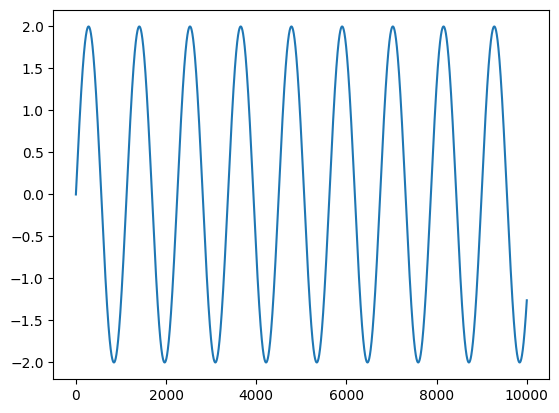

In [35]:
# Kick - a wave that is applied to the signal periodically, we choose a sine wave
phi = 0
f = 10 # Hz
A = 2
t = np.arange(10000)/sampling_frequency  # n = 10000, should be 50 in this case, but then the resolution is too low res =  sampling_frequency / frequency
print(t)
#t = np.linspace(0, 1, 50)
print(n)
kick = A * np.sin(2*np.pi*f*t + phi)
plt.plot(np.arange(10000), kick)

# example of a kick
'''
total_time = n_turns / f_rev
time = np.arange(0, total_time, 1/sampling_freq)
samples = np.sin(2*np.pi*f_ex*time + phi)


exciter = xt.Exciter(_context = ctx,
    samples = samples,
    sampling_frequency = sampling_freq,
    duration = None,  # defaults to waveform duration
    frev = f_rev,
    start_turn = 0,  # default, seconds
    knl = KNL,
    ksl = KSL,
)

# Add it to the line for tracking as usual
line.insert_element(
    element = exciter,
    name = 'RF_KO_EXCITER',
    index = 42,
)

insertion of the element in the beamline, the phase should be broken due to the kick
'''

In [36]:

#collider.build_trackers()
betx = twiss['betx'][0]
bety = twiss['bety'][0]
normal_emitt_x = 2.5e-6
normal_emitt_y = 2.5e-6

sigma_x = np.sqrt(betx*normal_emitt_x/(particles.gamma0*particles.beta0))[0]
sigma_y = np.sqrt(bety*normal_emitt_y/(particles.gamma0*particles.beta0))[0]
x = np.linspace(sigma_x, 3*sigma_x, 5)
px = np.zeros(5)
y = np.zeros(5)
py = np.zeros(5)
zeta = np.zeros(5)
delta = np.zeros(5)

particles = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9, x=x)

collider['lhcb1'].track(particles, num_turns=num_turns,
              turn_by_turn_monitor=True)

print(x)

ys = collider['lhcb1'].record_last_track.y
xs = collider['lhcb1'].record_last_track.x
print(xs)
qx_i = []
qy_i = []
for ii in range(len(x)):
    qx_i.append(PyNAFF.naff(xs[ii,:], turns=499)[0][1])
    qy_i.append(PyNAFF.naff(ys[ii,:], turns=499)[0][1])

[0.00020183 0.00030275 0.00040367 0.00050458 0.0006055 ]
[[ 2.01833363e-04  3.56515799e-04 -4.64319690e-04 ...  4.95898508e-04
  -9.18246590e-05 -4.28165577e-04]
 [ 3.02750045e-04  5.34773670e-04 -6.96479493e-04 ...  6.79282518e-04
  -5.63061855e-04 -2.64139615e-04]
 [ 4.03666727e-04  7.13031522e-04 -9.28639258e-04 ...  1.93820869e-04
  -9.93270258e-04  5.38984109e-04]
 [ 5.04583409e-04  8.91289352e-04 -1.16079898e-03 ... -1.05594132e-03
  -2.54045273e-04  1.24397807e-03]
 [ 6.05500090e-04  1.06954716e-03 -1.39295864e-03 ... -9.77162313e-04
   1.43765340e-03 -8.40799115e-05]]


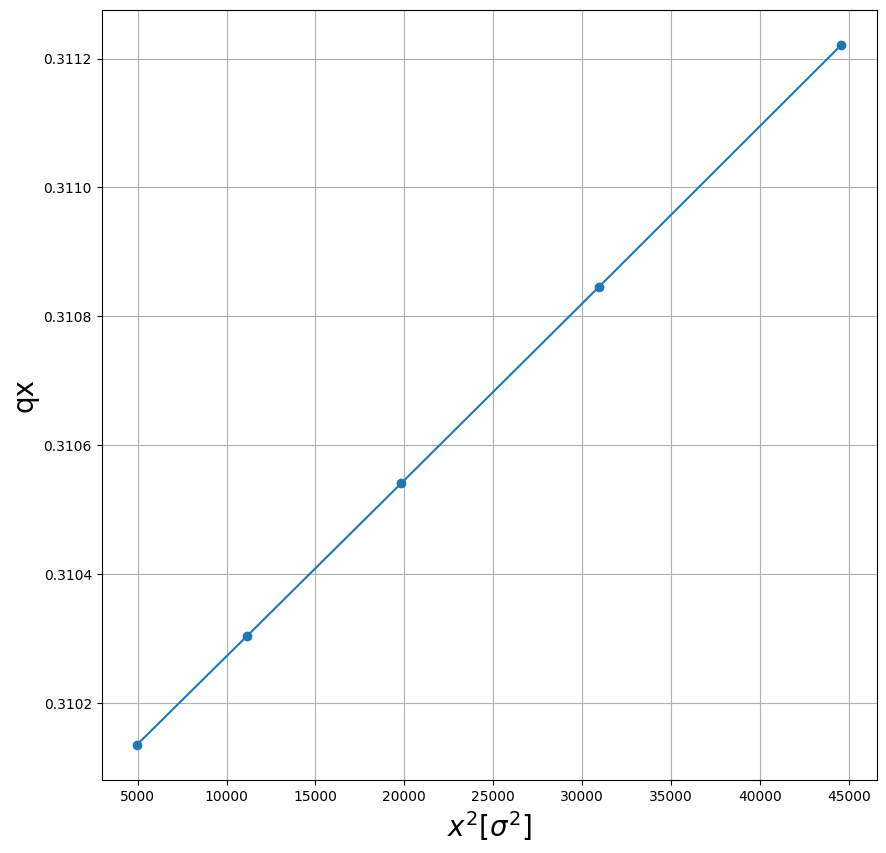

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.plot(qx_i,qy_i,'-o')
plt.plot(x**2/sigma_x**3,qx_i,'-o')
plt.xlabel(r'$x^{2}$[$\sigma^{2}$]', size = 20)
#plt.xlabel(r'qx', size = 20)

plt.ylabel(r'qx', size = 20)
plt.grid()

array([14.056875])

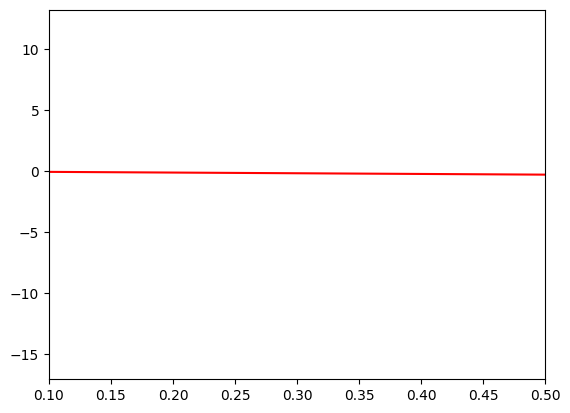

In [38]:
# 50 turns, tune -.37, reference value is -0.352
plt.plot(freq_try, fft_try, '.-r')
plt.xlim(0.1, 0.5)
# find the tune
twiss = line_edited.twiss()
twiss.dqx
ind = np.where(fft_try==np.max(fft_try))
fft_try[ind]
freq_try[ind]


568


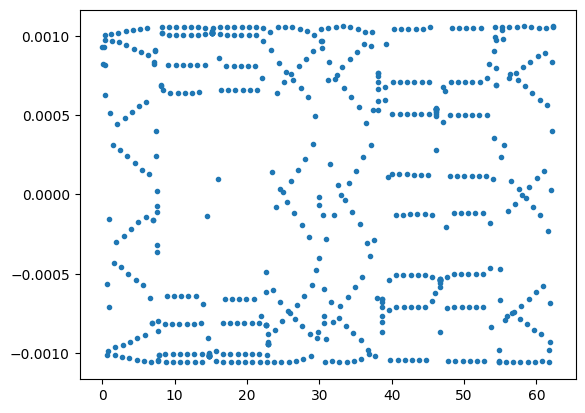

In [39]:
turn_0 = y_data_0
turn_1 = y_data
print(len(turn_0))
mux = twiss[:,'mymon.*'].mux 
#x=mux[10:30]
#y=turn_0[10:30]
x = mux
y = turn_0

plt.plot(x,y,'.')
#plt.plot(mux, turn_1)


[0.         0.15931191 0.40203214 0.46222845 0.49998421 0.65920207
 0.9020027  0.96221711 0.99996843 1.15909228 1.40197324 1.46220578
 1.49995265 1.65898255 1.90194377 1.96219444 1.99993687 2.15887287
 2.40191428 2.4621831 ]
[ 2.10968957e-01  8.63695038e-01 -2.32771536e+00  7.93427385e-02
  2.88365828e-01  2.52193772e-01  1.19527590e+00  7.10260339e-01
 -2.47452065e+00  4.69752000e-01  5.82882156e-01  6.51380485e-01
  7.60952814e-01 -2.42198640e+00  8.60222798e-01  7.15983540e-01
  8.58195335e-01 -2.42196093e+00  8.60170605e-01  7.15962350e-01
  8.58247653e-01 -2.42194012e+00  8.61616484e-01  7.19652643e-01
  8.61616483e-01 -2.42194001e+00  8.61616484e-01  7.19652643e-01
  8.61616483e-01 -2.42194001e+00  8.61616484e-01  7.19652643e-01
  8.61616483e-01 -2.42194001e+00  8.61616484e-01  7.19652643e-01
  8.61616483e-01 -2.42194001e+00  8.61616484e-01  7.19652643e-01
  8.61616483e-01 -2.42194001e+00  8.61616484e-01  7.19652643e-01
  8.61616483e-01 -2.42194001e+00  8.61616484e-01  7.17156196

Text(0, 0.5, 'wrapped phase advance')

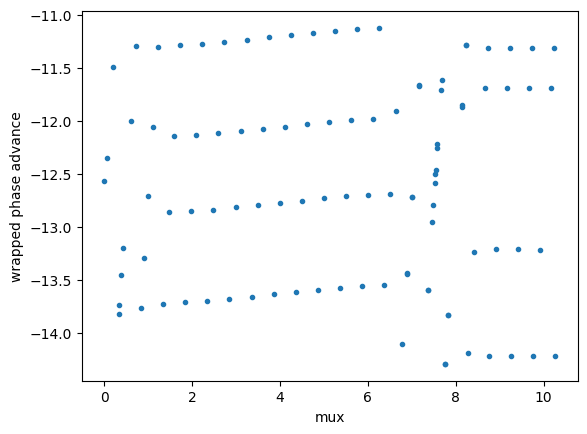

In [49]:
# find th sine wave that fits the data y = a*sin(2*pi*f*x + phi)
# find the phase advance for the first turn

def my_fit(i, A, phi):
    return A*np.sin(2*np.pi*i + phi)

def sine_function(x, amplitude, phase):
    return amplitude * np.sin(2 * np.pi  * x + phase) 
x_0 = x - x[0]
print(x_0)
# Fit the sine function to the data
initial_guess = [1e-8,  0]  # Initial guess for the parameter
my_phase = []
for start_bpm in range(100):
    x=mux[(0+start_bpm):(20+start_bpm)]
    y=turn_0[(0+start_bpm):(20+start_bpm)]
    x_0 = x - x[0]
    #print(x_0)
    #my_fit = [my_fit(i, 1.05892633e-08,-1.63081640e-01) for i in x]
    # plt.plot(x_0, my_fit)
    # plt.plot(x_0,y,'.r')


    fit_params, _ = curve_fit(sine_function, x_0, y, p0=initial_guess)
    my_phase.append(fit_params[1])

#plt.axhline(y=1/2, linestyle='dashed')
#plt.axhline(y=-1/2, linestyle='dashed')
plt.plot(mux[0:len(my_phase)],np.unwrap(np.array(my_phase)), '.')
print(np.diff(np.unwrap(np.array(my_phase))))
plt.xlabel('mux')
plt.ylabel('wrapped phase advance')
#print(my_phase)
#plt.plot(x_0, y, '.-r')

#for i in range(5):
#    plt.axhline(y=1/2*i, linestyle='dashed')
#    plt.axhline(y=-1/2*i, linestyle='dashed')

In [42]:
np.diff(np.array(my_phase))

array([ 2.53437102e+01, -1.17026756e+01,  7.93536936e+01, -7.53188809e+01,
        6.94034042e+01, -7.51460299e+01, -5.53533919e+01,  5.09757428e+01,
       -9.04391149e+01,  7.58679757e+01,  6.86606746e+00,  1.95009364e+01,
        8.87255471e+01, -9.03865807e+01,  2.59929640e+01, -4.32663136e+01,
        7.14138064e+00, -8.41033699e+01,  8.25415796e+01,  6.99914766e+00,
        9.51060273e+01, -9.03865344e+01, -5.42156882e+00, -4.32626445e+01,
        2.59943577e+01, -7.15369784e+01,  6.36934696e+01,  6.98346910e+01,
        5.11270989e+01, -8.70512532e+00, -8.71029778e+01, -1.18467180e+01,
        7.14480179e+00,  3.86124530e+00, -5.42156882e+00,  1.32860233e+01,
        8.88262108e+01, -8.70512532e+00, -6.82534219e+01, -2.44130886e+01,
       -9.33861631e+01,  1.64276159e+01,  6.36934696e+01,  6.98346910e+01,
       -4.31206807e+01,  2.89939865e+01, -3.68374954e+01, -4.95483263e+01,
       -6.19750593e+01,  9.81078390e+01,  7.14478153e+00,  5.09825870e+01,
        1.34231837e+01, -

-12.564659564065762
12.779050621850022
13.642745660052887
80.43006867510996
80.50941141358669
80.79777724145767
81.0499710130323
82.24524691476262
82.95550725412181
83.62257926051592
84.092331260836
84.6752134167936
85.32659390189328
95.51232467626066
96.23193092636446
97.09215372395717
97.80813726402477
98.66633259893679
99.38596432724641
100.24613493227643
100.9620972818072
101.82034493519778
102.53999746593634
103.40161394946917
104.12126659239517
104.98288307571184
105.70253571846628
106.56415220200324
107.2838048449253
108.14542132823776
108.86507397099628
109.72669045453718
110.44634309745514
111.30795958076381
112.02761222352659
112.88922870707152
113.60888134998477
114.47049783328988
115.19015047605704
116.05176695960549
116.77141960251436
117.6330360858161
118.3526887285878
119.21430521213945
119.9339578550438
120.79557433834225
121.51522698111857
122.3768434646733
123.0939996603229
123.95079341164934
124.66926016927124
125.53085638891241
126.24796092776738
127.10477405459461


Text(0, 0.5, 'unwrapped phase')

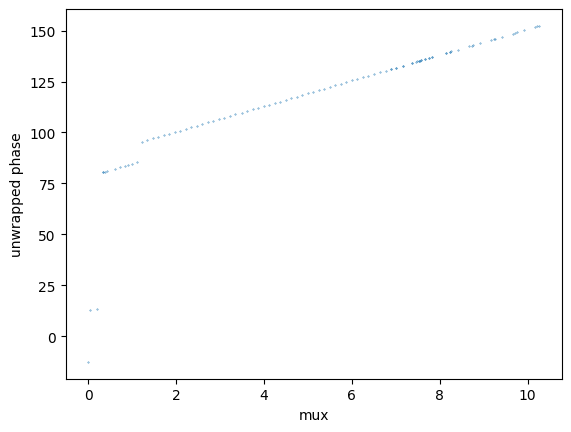

In [43]:
my_phi = my_phase

for i in range(len(my_phase)-1):
    print(my_phase[i])
    while np.diff(np.array(my_phi))[i]<0:
        if np.diff(np.array(my_phi))[i]<0:
             my_phase[i+1] = my_phase[i+1] + np.pi
#print(my_phase)
plt.scatter(mux[0:len(my_phase)+0],np.array(my_phase), s = 0.1)
#print(mux[10:len(my_phase)+10],np.diff(np.array(my_phase)))
plt.xlabel('mux')
plt.ylabel('unwrapped phase')
#plt.xlim(0,6)
#plt.ylim(0, 200)

In [45]:
mux[10]*2*np.pi

5.71559656067329

In [46]:
phase_deg = np.mod(np.linspace(0 ,720, 19), 360) - 180

In [47]:
phase_deg

array([-180., -140., -100.,  -60.,  -20.,   20.,   60.,  100.,  140.,
       -180., -140., -100.,  -60.,  -20.,   20.,   60.,  100.,  140.,
       -180.])

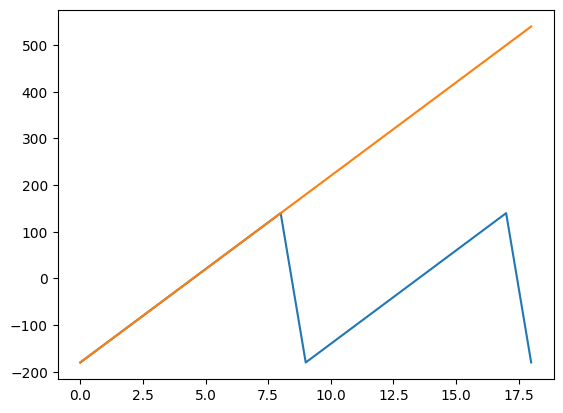

In [48]:
plt.plot(phase_deg)
plt.plot(np.unwrap(phase_deg, period=360))